In [1]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Browser Function Calling with the Vertex AI Gemini API & Python SDK

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/gemini/function-calling/intro_function_calling.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/function-calling/intro_function_calling.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/function-calling/intro_function_calling.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
</table>


In [2]:
#upgrade the sdk for Gemini
# !pip3 install --upgrade --user google-cloud-aiplatform

In [3]:
# !pip install playwright > /dev/null
# !pip install  lxml

# If this is your first time using playwright, you'll have to install a browser executable.
# Running `playwright install` by default installs a chromium browser executable.
# !playwright install
# Also run this:
# !playwright install dependencies

#### We will be utilizing pre-built Langchain tools for the Google Search

____________

## Google Search
[Langchain Guide](https://python.langchain.com/docs/integrations/tools/google_search)

This notebook goes over how to use the google search component.

First, you need to set up the proper API keys and environment variables. To set it up, create the GOOGLE_API_KEY in the Google Cloud credential console (https://console.cloud.google.com/apis/credentials) and a GOOGLE_CSE_ID using the Programmable Search Engine (https://programmablesearchengine.google.com/controlpanel/create). Next, it is good to follow the instructions found here.

Then we will need to set some environment variables.

```python
import os

os.environ["GOOGLE_CSE_ID"] = ""
os.environ["GOOGLE_API_KEY"] = ""
```

In [4]:
#using a local json key - careful don't commit that file!
import json
import os

f = open('config.json')
config = json.load(f)
f.close()


os.environ["GOOGLE_CSE_ID"] = config['SEARCH_ID']
os.environ["GOOGLE_API_KEY"] = config['CSE_KEY']

In [44]:

import requests
from vertexai.preview.generative_models import (
    Content,
    FunctionDeclaration,
    GenerativeModel,
    Part,
    Tool,
    Image,
)

from langchain.utilities import GoogleSearchAPIWrapper

search = GoogleSearchAPIWrapper()


#### Create the Langchain tool for search

We will want to create a custom tool that leverages the `results` method

In [6]:

from google.cloud.aiplatform_v1beta1.types.tool import FunctionCall
from vertexai.generative_models._generative_models import GenerationResponse
from typing import List

def get_parts_from_response(response: GenerationResponse) -> List[FunctionCall]:
    """
    Get the parts from a generation response.

    Args:
        response: The generation response.
        
    Returns:
        A list of parts.
    """
    return(response.candidates[0].content)

In [7]:
search_func = FunctionDeclaration(
    name="google_search",
    description="Perform a Google Search",
    parameters={
    "type": "object",
    "properties": {
        "query": {
            "type": "string",
            "description": "Google Search Query"
        },
        "num_results": {
            "type": "integer",
            "description": "Number of results to return"        
        }
    }
},
)


You can then define a tool for the LLM to call that includes the `search_func`:

In [8]:
search_tool = Tool(
    function_declarations=[search_func],
)

### Use the Gemini Pro model

The Gemini Pro (`gemini-pro`) model is designed to handle natural language tasks, multiturn text and code chat, and code generation.

In [9]:
model = GenerativeModel("gemini-pro")

In [57]:
prompt = "What is the top news on Arsenal football using the top 5 results?"

response = model.generate_content(
    prompt,
    generation_config={"temperature": 0},
    tools=[search_tool]
)
response

candidates {
  content {
    role: "model"
    parts {
      function_call {
        name: "google_search"
        args {
          fields {
            key: "num_results"
            value {
              number_value: 5.0
            }
          }
          fields {
            key: "query"
            value {
              string_value: "Top news on Arsenal football"
            }
          }
        }
      }
    }
  }
  finish_reason: STOP
  safety_ratings {
    category: HARM_CATEGORY_HARASSMENT
    probability: NEGLIGIBLE
  }
  safety_ratings {
    category: HARM_CATEGORY_HATE_SPEECH
    probability: NEGLIGIBLE
  }
  safety_ratings {
    category: HARM_CATEGORY_SEXUALLY_EXPLICIT
    probability: NEGLIGIBLE
  }
  safety_ratings {
    category: HARM_CATEGORY_DANGEROUS_CONTENT
    probability: NEGLIGIBLE
  }
}
usage_metadata {
  prompt_token_count: 15
  total_token_count: 15
}

##### Quick inspection of one function call

In [58]:
response.candidates[0].content.parts[0].function_call

name: "google_search"
args {
  fields {
    key: "num_results"
    value {
      number_value: 5.0
    }
  }
  fields {
    key: "query"
    value {
      string_value: "Top news on Arsenal football"
    }
  }
}

#### Search options can also be used

https://developers.google.com/custom-search/v1/reference/rest/v1/cse/list

In [59]:
function_calls = get_parts_from_response(response)

function_calls = function_calls.parts
function_calls

search_options = {
    'filter': 1, #dup content filter
    'dateRestrict': 'w[2]', #last two weeks
    'searchType': 'image',
    # 'exactTerms': 'car',
    # 'excludeTerms': 'cat',
}

single_function_args = function_calls[0].function_call.args
unrolled_args = {k: v for k, v in single_function_args.items()}
unrolled_args.update({'search_params': search_options})
tool_res = search.results(** unrolled_args)
tool_res

[{'title': 'Arsenal transfer news and rumours today: Victor Nelsson at top of ...',
  'link': 'https://assets.goal.com/v3/assets/bltcc7a7ffd2fbf71f5/blt06bd664f4647a802/644991c92c93e11ace51fd44/Rob_Holding_Arsenal_2022-23.jpg?auto=webp&format=pjpg&width=3840&quality=60',
  'snippet': 'Arsenal transfer news and rumours today: Victor Nelsson at top of ...'},
 {'title': 'Arsenal transfer news: Hector Bellerin wanted by Inter Milan to ...',
  'link': 'https://e0.365dm.com/21/04/2048x1152/skysports-hector-bellerin-arsenal_5350425.jpg?20210421081520',
  'snippet': 'Arsenal transfer news: Hector Bellerin wanted by Inter Milan to ...'},
 {'title': 'Arsenal injury update: Jurrien Timber, Oleksandr Zinchenko and ...',
  'link': 'https://s.yimg.com/ny/api/res/1.2/ef2xz4lXMMDYuWEIucgp3A--/YXBwaWQ9aGlnaGxhbmRlcjt3PTY0MDtoPTQyNg--/https://media.zenfs.com/en/evening_standard_239/da725f159021e0febab8eb1f942aa3fd',
  'snippet': 'Arsenal injury update: Jurrien Timber, Oleksandr Zinchenko and ...'},
 {'t

In [60]:
#### How To use Google Search + Multimodal (Vision) Gemini

Helper functions, then download image locally

SyntaxError: invalid syntax (1076199338.py, line 3)

In [61]:
multimodal_model = GenerativeModel("gemini-pro-vision")
import http.client
import typing
import urllib.request

import IPython.display
from PIL import Image as PIL_Image
from PIL import ImageOps as PIL_ImageOps


def display_images(
    images: typing.Iterable[Image],
    max_width: int = 600,
    max_height: int = 350,
) -> None:
    for image in images:
        pil_image = typing.cast(PIL_Image.Image, image._pil_image)
        if pil_image.mode != "RGB":
            # RGB is supported by all Jupyter environments (e.g. RGBA is not yet)
            pil_image = pil_image.convert("RGB")
        image_width, image_height = pil_image.size
        if max_width < image_width or max_height < image_height:
            # Resize to display a smaller notebook image
            pil_image = PIL_ImageOps.contain(pil_image, (max_width, max_height))
        IPython.display.display(pil_image)


def get_image_bytes_from_url(image_url: str) -> bytes:
    with urllib.request.urlopen(image_url) as response:
        response = typing.cast(http.client.HTTPResponse, response)
        image_bytes = response.read()
    return image_bytes


def load_image_from_url(image_url: str) -> Image:
    image_bytes = get_image_bytes_from_url(image_url)
    return Image.from_bytes(image_bytes)

def get_url_from_gcs(gcs_uri: str) -> str:
    # converts gcs uri to url for image display.
    url = "https://storage.googleapis.com/" + gcs_uri.replace("gs://", "").replace(" ", "%20")
    return url

def print_multimodal_prompt(contents: list):
    """
    Given contents that would be sent to Gemini,
    output the full multimodal prompt for ease of readability.
    """
    for content in contents:
        if isinstance(content, Image):
            display_images([content])
        elif isinstance(content, Part):
            url = get_url_from_gcs(content.file_data.file_uri)
            IPython.display.display(load_image_from_url(url))
        else:
            print(content)

-------Prompt--------


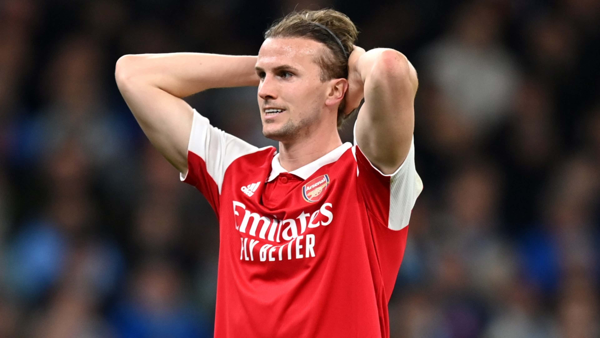

Describe this image?

-------Response--------
 This is a picture of Arsenal player, Ben White. He has his hands on his head and looks frustrated. He is most likely upset because his team is losing.-------Prompt--------


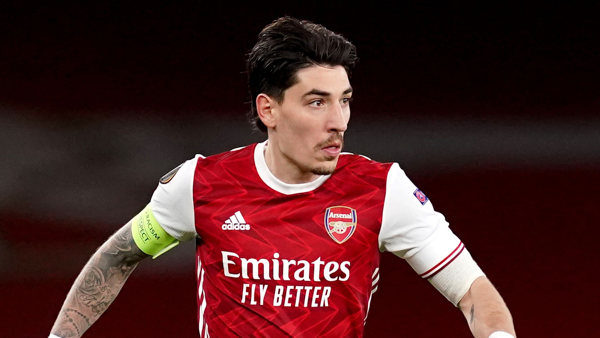

Describe this image?

-------Response--------
 This is a photo of Dani Ceballos playing for Arsenal. He is wearing a red jersey with white sleeves. The jersey has the Emirates logo on the chest and the Adidas logo on the right sleeve. He is also wearing black shorts and socks. He has his hair in a ponytail and a beard. He is looking to his left. The background is blurred.-------Prompt--------


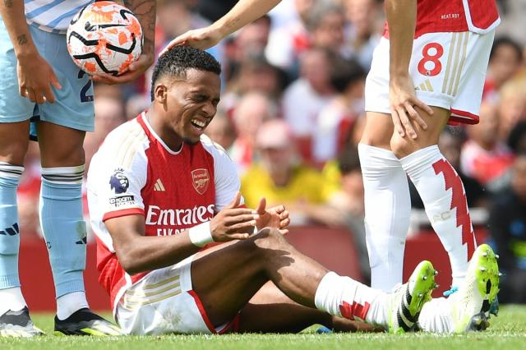

Describe this image?

-------Response--------
 The image shows Arsenal player Reiss Nelson lying on the ground injured during a match. He is holding his leg and looks to be in pain. Arsenal's Emile Smith Rowe is consoling him.-------Prompt--------


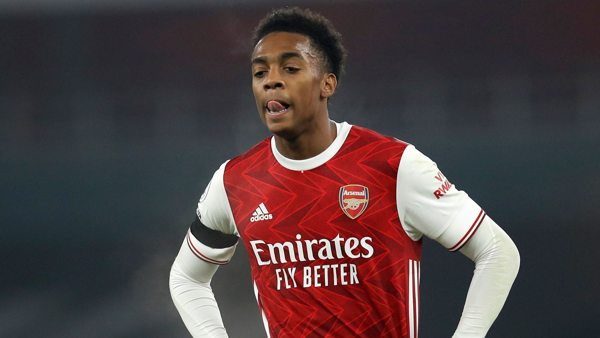

Describe this image?

-------Response--------
 The image shows a young male football player in a red and white jersey with his hands on his hips looking to the left with his tongue out.-------Prompt--------


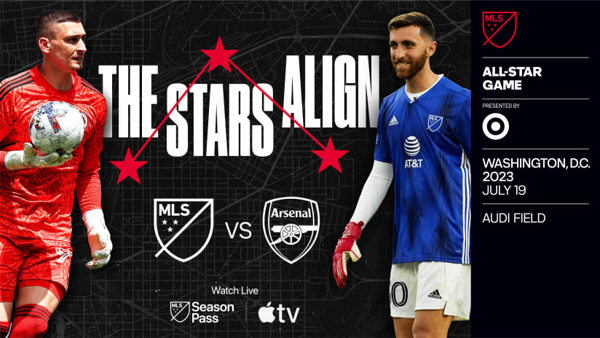

Describe this image?

-------Response--------
 This is a poster for the 2023 MLS All-Star Game. The game will be played between the MLS All-Stars and Arsenal FC on July 19th at Audi Field in Washington, D.C. The poster features two goalkeepers, one from each team. The MLS All-Star goalkeeper is wearing a red jersey, while the Arsenal goalkeeper is wearing a blue jersey. The poster also features the logos of both teams, as well as the MLS All-Star logo.

In [62]:
import urllib.request 

for res in tool_res:
    url = res['link']
    try:
        urllib.request.urlretrieve(url, "image.png") 

        image = Image.load_from_file("image.png")
        # Prepare contents
        prompt = "Describe this image?"
        contents = [image, prompt]

        responses = multimodal_model.generate_content(contents, stream=True)
        print("-------Prompt--------")
        print_multimodal_prompt(contents)

        print("\n-------Response--------")
        for response in responses:
            print(response.text, end="")
    except:
        pass

In [13]:
from google.cloud.aiplatform_v1beta1.types.tool import FunctionCall
from vertexai.generative_models._generative_models import GenerationResponse
from typing import List

def get_parts_from_response(response: GenerationResponse) -> List[FunctionCall]:
    """
    Get the parts from a generation response.

    Args:
        response: The generation response.

    Returns:
        A list of parts.
    """
    return(response.candidates[0].content)

#### We will now do a mult-turn chat
Example can be found here on [function calling](https://cloud.google.com/vertex-ai/docs/generative-ai/multimodal/function-calling#function-calling-one-and-a-half-turn-curl-sample)

In [14]:
model = GenerativeModel("gemini-pro", 
                        generation_config={"temperature": 0},
                        tools=[search_tool])
chat = model.start_chat()

In [15]:
from pprint import pprint

prompt = "How did deepmind recently solve an unsolvable math problem (december 2023), look for the top 5 articles"
# while_loop = True

# while while_loop:
response = chat.send_message(prompt)
# pprint(response)
function_calls = get_parts_from_response(response)

function_calls = function_calls.parts
function_calls

[function_call {
   name: "google_search"
   args {
     fields {
       key: "num_results"
       value {
         number_value: 5.0
       }
     }
     fields {
       key: "query"
       value {
         string_value: "Deepmind solved unsolvable math problem December 2023"
       }
     }
   }
 }]

In [16]:
{k: v for k, v in single_function_args.items()}

{'num_results': 8.0, 'query': 'Top news on Panera Bread'}

In [17]:
single_function_args = function_calls[0].function_call.args
tool_res = search.results(** {k: v for k, v in single_function_args.items()})
print(tool_res)

[{'title': 'DeepMind AI outdoes human mathematicians on unsolved problem', 'link': 'https://www.nature.com/articles/d41586-023-04043-w', 'snippet': '4 days ago ... 14 December 2023. DeepMind AI outdoes human mathematicians on unsolved problem. Large language model improves on efforts to solve\xa0...'}, {'title': 'Google DeepMind used a large language model to solve an ...', 'link': 'https://www.technologyreview.com/2023/12/14/1085318/google-deepmind-large-language-model-solve-unsolvable-math-problem-cap-set/', 'snippet': 'Google DeepMind used a large language model to solve ... December 14, 2023. scraps of old algebra textbook piled with an old photo of a woman surrounded by\xa0...'}, {'title': 'Google DeepMind Uses LLM To Solve Unsolvable Math Problem ...', 'link': 'https://science.slashdot.org/story/23/12/14/1933219/google-deepmind-uses-llm-to-solve-unsolvable-math-problem', 'snippet': 'Posted by BeauHD on Thursday December 14, 2023 @10:30PM from the what-will-they-think-of-next dept

In [18]:
model_response = chat.send_message(
  Part.from_function_response(
      name="google_search",
      response={
          "content": {"google_search_results": tool_res},
      }
  ),
  tools=[search_tool]
)
print("model_response\n", model_response)

model_response
 candidates {
  content {
    role: "model"
    parts {
      text: "1. **DeepMind AI Outdoes Human Mathematicians on Unsolved Problem**\n[Nature](https://www.nature.com/articles/d41586-023-04043-w)\n\n2. **Google DeepMind Used a Large Language Model to Solve an Unsolvable Math Problem**\n[Technology Review](https://www.technologyreview.com/2023/12/14/1085318/google-deepmind-large-language-model-solve-unsolvable-math-problem-cap-set/)\n\n3. **Google DeepMind Uses LLM To Solve Unsolvable Math Problem**\n[Slashdot](https://science.slashdot.org/story/23/12/14/1933219/google-deepmind-uses-llm-to-solve-unsolvable-math-problem)\n\n4. **Google DeepMind used a large language model to solve an unsolvable math problem**\n[Twitter](https://twitter.com/sarahhbana?lang=en)\n\n5. **Google DeepMind used a large language model to solve an unsolvable math problem**\n[Simon Willison](https://simonwillison.net/2023/Dec/16/)"
    }
  }
  finish_reason: STOP
  safety_ratings {
    category: 

In [19]:
chat.send_message(prompt)

candidates {
  content {
    role: "model"
    parts {
      text: "1. **DeepMind AI Outdoes Human Mathematicians on Unsolved Problem**\n[Nature](https://www.nature.com/articles/d41586-023-04043-w)\n\nThis article reports that DeepMind\'s AlphaTensor AI system has solved a previously unsolvable math problem known as the \"CAP-set problem.\" The problem involves finding the smallest set of numbers that can be used to represent all other numbers in a given range. AlphaTensor was able to find a set of just 17 numbers that can represent all numbers between 1 and 1000.\n\n2. **Google DeepMind Used a Large Language Model to Solve an Unsolvable Math Problem**\n[Technology Review](https://www.technologyreview.com/2023/12/14/1085318/google-deepmind-large-language-model-solve-unsolvable-math-problem-cap-set/)\n\nThis article provides a more in-depth look at how AlphaTensor solved the CAP-set problem. It explains that AlphaTensor used a technique called \"reinforcement learning\" to train itself 

In [20]:
followup_prompt = "what are other related google search topics on this I could research? Use the google search tool"

In [21]:
response = chat.send_message(followup_prompt)
function_calls = get_parts_from_response(response)

function_calls = function_calls.parts
single_function_args = function_calls[0].function_call.args
tool_res = search.results(** {k: v for k, v in single_function_args.items()})
print(tool_res)

[{'title': 'DeepMind AI outdoes human mathematicians on unsolved problem', 'link': 'https://www.nature.com/articles/d41586-023-04043-w', 'snippet': '4 days ago ... But its inventors say that the method, described in Nature on 14 December, could be applied to a variety of questions in maths and computer\xa0...'}, {'title': 'Google DeepMind used a large language model to solve an ...', 'link': 'https://www.technologyreview.com/2023/12/14/1085318/google-deepmind-large-language-model-solve-unsolvable-math-problem-cap-set/', 'snippet': 'Google DeepMind used a large language model to solve ... December 14, 2023. scraps of old algebra textbook piled with an old photo of a woman surrounded by\xa0...'}, {'title': 'Google DeepMind Uses LLM To Solve Unsolvable Math Problem ...', 'link': 'https://science.slashdot.org/story/23/12/14/1933219/google-deepmind-uses-llm-to-solve-unsolvable-math-problem', 'snippet': 'Posted by BeauHD on Thursday December 14, 2023 @10:30PM from the what-will-they-think-of

In [22]:
model_response = chat.send_message(
  Part.from_function_response(
      name="google_search",
      response={
          "content": {"google_search_results": tool_res},
      }
  ),
  tools=[search_tool]
)
print("model_response\n", model_response)

model_response
 candidates {
  content {
    role: "model"
    parts {
      text: " Here are some other related Google search topics on DeepMind solving an unsolvable math problem in December 2023 that you could research:\n\n* **Applications of AlphaTensor**\n* **Implications of AlphaTensor\'s breakthrough**\n* **Other math problems that AlphaTensor could solve**\n* **How AlphaTensor could be used to improve AI**\n* **The future of AI and mathematics**\n\nYou could also search for articles and blog posts that discuss AlphaTensor\'s achievement in more detail. For example, you could search for:\n\n* **DeepMind AlphaTensor explained**\n* **How AlphaTensor works**\n* **AlphaTensor\'s impact on mathematics**\n* **AlphaTensor\'s potential applications**\n\nI hope this helps!"
    }
  }
  finish_reason: STOP
  safety_ratings {
    category: HARM_CATEGORY_HARASSMENT
    probability: NEGLIGIBLE
  }
  safety_ratings {
    category: HARM_CATEGORY_HATE_SPEECH
    probability: NEGLIGIBLE
  }
  sa

In [23]:
final_prompt="please create a nice bulleted summary of this topic"
final_response = chat.send_message(final_prompt)

pprint(final_response.candidates[0].content.parts[0].text)

("**DeepMind's AlphaTensor Solves Unsolvable Math Problem (December 2023)**\n"
 '\n'
 '* AlphaTensor, a new AI system developed by DeepMind, has solved a '
 'previously unsolvable math problem known as the "CAP-set problem."\n'
 '* The CAP-set problem involves finding the smallest set of numbers that can '
 'be used to represent all other numbers in a given range.\n'
 '* AlphaTensor was able to find a set of just 17 numbers that can represent '
 'all numbers between 1 and 1000.\n'
 '* AlphaTensor used a technique called "reinforcement learning" to train '
 'itself to find the smallest possible set of numbers that could represent all '
 'other numbers in a given range.\n'
 "* AlphaTensor's breakthrough could have implications for a variety of "
 'fields, including artificial intelligence, mathematics, and computer '
 'science.\n'
 '\n'
 '**Potential Applications of AlphaTensor**\n'
 '\n'
 '* AlphaTensor could be used to develop new algorithms for solving complex '
 'mathematical problem